In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from scipy.io import arff
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
def process_files(file_type, data_path, start_sid=1):
  final_df = pd.DataFrame()

  for i in range(1, 25):
    filename = f"NATOPSDimension{i}_{file_type}.arff"
    filepath = os.path.join(data_path, filename)

    df_dimension, meta = arff.loadarff(open(filepath, 'r'))

    df = pd.DataFrame(df_dimension)
    final_df['isTest'] = 1 if file_type == "TEST" else 0

    # Flatten each row into a single column and track the row number (SID)
    flattened_column = []
    sids = []
    class_attr = []
    for index, row in df.iterrows():
        class_attribute = int(float(row[-1].decode('utf-8')))-1 # to make the class from 0-5
        for value in row[:-1]:  # Exclude the last element (class attribute)
            flattened_column.append(value)
            sids.append(start_sid + index)  # Adjusted row number as SID
            class_attr.append(class_attribute)

    final_df[f'fea_{i}'] = flattened_column
    if i == 24: # SID and class attributes only need to be added once at the end
      final_df['sid'] = sids
      final_df['class'] = class_attr



  return final_df


data_path = "/content/drive/MyDrive/NATOPS/"
train_df = process_files('TRAIN', data_path)

# Find the maximum SID from the training data to continue for the test data
max_sid = train_df['sid'].max()

# Process testing files, starting SIDs from the next available number after training data
test_df = process_files('TEST', data_path, start_sid=max_sid + 1)

# Concatenate training and testing data
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Save the final DataFrame to a CSV file
combined_df.to_csv('combined_data.csv', index=False)

In [ ]:
combined_df.head()

,isTest,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,...,fea_17,fea_18,fea_19,fea_20,fea_21,fea_22,fea_23,fea_24,sid,class
0,0,-0.372758,-1.821679,-0.846321,0.465208,-2.015072,-0.839242,-0.564097,-0.796225,-0.149604,...,-1.534954,-0.673190,-0.536343,-1.626957,-0.594337,0.619205,-1.771773,-0.810086,1,3
1,0,-0.367844,-1.841987,-0.846325,0.467033,-2.007557,-0.838151,-0.564499,-0.797622,-0.150012,...,-1.532795,-0.671919,-0.533816,-1.642514,-0.605328,0.617045,-1.796660,-0.818863,1,3
2,0,-0.378445,-1.821358,-0.839571,0.471135,-2.010042,-0.832021,-0.563753,-0.795704,-0.151608,...,-1.532478,-0.671555,-0.526319,-1.697145,-0.624302,0.624789,-1.738568,-0.788060,1,3
3,0,-0.386751,-1.845643,-0.848031,0.506153,-2.032552,-0.841696,-0.565008,-0.790238,-0.152350,...,-1.535441,-0.672198,-0.554538,-1.644413,-0.602884,0.634100,-1.749744,-0.816695,1,3
4,0,-0.417101,-1.941721,-0.885500,0.611207,-1.953282,-0.902529,-0.573550,-0.799730,-0.169575,...,-1.482552,-0.659393,-0.576196,-1.763092,-0.694843,0.680086,-1.664565,-0.857897,1,3


In [ ]:
combined_df.shape

(18360, 27)

In [ ]:
data = pd.read_csv('combined_data.csv')
feature_columns = [col for col in data.columns if col.startswith('fea')]
features = data[feature_columns]
n_clusters = 4  # I used 4 because of elbow plot given below
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
data['cluster'] = kmeans.fit_predict(features)+1
cluster_ratios = data.groupby('sid')['cluster'].value_counts(normalize=True).unstack(fill_value=0)
cluster_ratio_data = cluster_ratios.reset_index()
cluster_ratio_data.columns = ['sid'] + [f'cluster_{i+1}_ratio' for i in range(n_clusters)]

final_data = pd.merge(data, cluster_ratio_data, on='sid', how='left')
final_data = final_data.drop(feature_columns, axis=1)

final_data.to_csv('final_data_p2.csv', index=False)
print(final_data.head())

   isTest  sid  class  cluster  cluster_1_ratio  cluster_2_ratio  \
0       0    1      3        1          0.45098              0.0   
1       0    1      3        1          0.45098              0.0   
2       0    1      3        1          0.45098              0.0   
3       0    1      3        1          0.45098              0.0   
4       0    1      3        1          0.45098              0.0   

   cluster_3_ratio  cluster_4_ratio  
0         0.294118         0.254902  
1         0.294118         0.254902  
2         0.294118         0.254902  
3         0.294118         0.254902  
4         0.294118         0.254902  


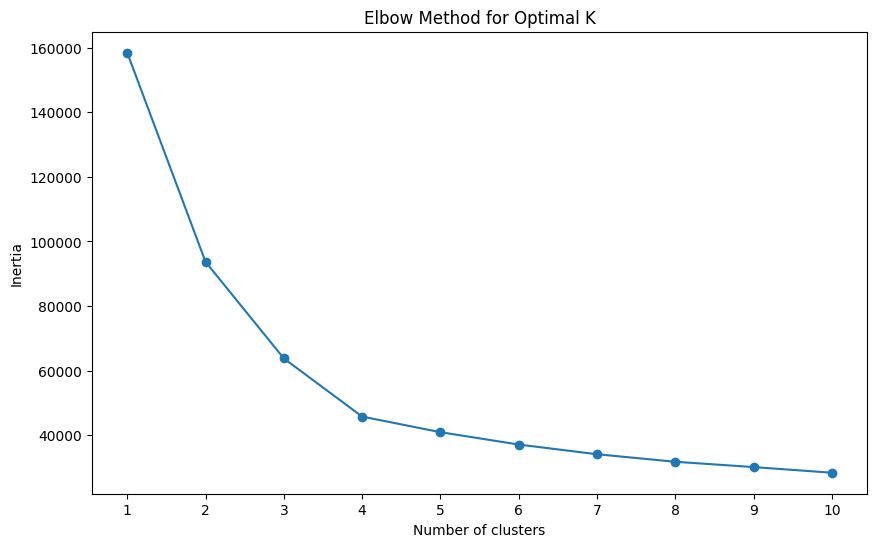

In [ ]:
feature_columns = [col for col in data.columns if col.startswith('fea')]
features = data[feature_columns]

scaler = StandardScaler()

wcss = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k,n_init=10, random_state=0)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.show()